In [6]:
import requests
import pandas as pd
import json
import os
import logging
import boto3
from botocore.exceptions import ClientError


In [23]:
def get_data(url, month, days):
    data = None
    data = requests.get(url).json()
    
    for i in range(2, days+1):
        url = 'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date=20210{month}{i}&json'.format(month=month,i=i)
        r = requests.get(url).json()
        data += r
        
    return data
    
    

In [28]:
url = 'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date=20210101&json'
month = 1
days_jan = 31
jan = get_data(url, month, days_jan)

In [31]:
url = 'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date=20210201&json'
month = 2
days_feb = 28
feb = get_data(url, month, days_feb)

In [35]:
url = 'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?date=20210301&json'
month = 3
days_mar = 24
march = get_data(url, month, days_mar)

In [36]:
data = jan + feb + march
df = pd.json_normalize(data)

In [49]:
data_csv = df.to_csv('data.csv')

In [21]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [50]:
upload_file('data.csv', 'my-backet-lab2')
os.remove("data.csv")

# `Read from bucket`

In [12]:
s3 = boto3.client('s3')
s3.download_file('my-backet-lab2', 'data.csv', 'data.csv')

In [13]:
data = pd.read_csv('data.csv')

In [15]:
new_df = data[['rate', 'cc', 'exchangedate']]

In [16]:
usd = new_df.loc[new_df['cc'] == 'USD']
usd = usd.rename(columns={'rate': 'USD'})
eur = new_df.loc[new_df['cc'] == 'EUR']
eur = eur.rename(columns={'rate': 'EUR'})

In [17]:
usd

,USD,cc,exchangedate
26,28.2746,USD,01.01.2021
87,28.2746,USD,02.01.2021
148,28.2746,USD,03.01.2021
209,28.2746,USD,04.01.2021
270,28.4310,USD,05.01.2021
...,...,...,...
4784,27.6828,USD,20.03.2021
4845,27.6828,USD,21.03.2021
4906,27.7184,USD,22.03.2021
4967,27.6871,USD,23.03.2021


In [18]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt


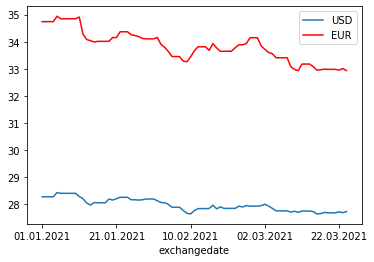

<Figure size 432x288 with 0 Axes>

In [24]:
ax = plt.gca()

usd.plot(kind='line',x='exchangedate',y='USD',ax=ax)
eur.plot(kind='line',x='exchangedate',y='EUR', color='red', ax=ax)

plt.show()

plt.savefig('usd_eur.png', dpi=300, bbox_inches='tight')
plt.savefig('usd_eur.pdf', dpi=300, bbox_inches='tight')

In [26]:
upload_file('usd_eur.png', 'my-backet-lab2')
upload_file('usd_eur.pdf', 'my-backet-lab2')

True